In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("claytonmiller/buildingdatagenomeproject2")

print("Path to dataset files:", path)

100%|██████████| 263M/263M [00:01<00:00, 177MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/claytonmiller/buildingdatagenomeproject2/versions/3


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
# List all files in the dataset folder
for root, dirs, files in os.walk(path):
    for file in files:
        print(os.path.join(root, file))

/root/.cache/kagglehub/datasets/claytonmiller/buildingdatagenomeproject2/versions/3/gas.csv
/root/.cache/kagglehub/datasets/claytonmiller/buildingdatagenomeproject2/versions/3/weather.csv
/root/.cache/kagglehub/datasets/claytonmiller/buildingdatagenomeproject2/versions/3/solar.csv
/root/.cache/kagglehub/datasets/claytonmiller/buildingdatagenomeproject2/versions/3/water_cleaned.csv
/root/.cache/kagglehub/datasets/claytonmiller/buildingdatagenomeproject2/versions/3/steam.csv
/root/.cache/kagglehub/datasets/claytonmiller/buildingdatagenomeproject2/versions/3/hotwater_cleaned.csv
/root/.cache/kagglehub/datasets/claytonmiller/buildingdatagenomeproject2/versions/3/electricity_cleaned.csv
/root/.cache/kagglehub/datasets/claytonmiller/buildingdatagenomeproject2/versions/3/irrigation_cleaned.csv
/root/.cache/kagglehub/datasets/claytonmiller/buildingdatagenomeproject2/versions/3/steam_cleaned.csv
/root/.cache/kagglehub/datasets/claytonmiller/buildingdatagenomeproject2/versions/3/chilledwater.csv

In [4]:
# Define dataset path
path = "/root/.cache/kagglehub/datasets/claytonmiller/buildingdatagenomeproject2/versions/3/"

# Load HVAC and supporting data
chilledwater = pd.read_csv(os.path.join(path, 'chilledwater_cleaned.csv'), index_col='timestamp', parse_dates=True)
hotwater = pd.read_csv(os.path.join(path, 'hotwater_cleaned.csv'), index_col='timestamp', parse_dates=True)
weather = pd.read_csv(os.path.join(path, 'weather.csv'), index_col='timestamp', parse_dates=True)
metadata = pd.read_csv(os.path.join(path, 'metadata.csv'))

# Inspect data
print("Chilled Water Data Shape:", chilledwater.shape)
print("Hot Water Data Shape:", hotwater.shape)
print("Weather Data Shape:", weather.shape)
print("Metadata Columns:", metadata.columns)

Chilled Water Data Shape: (17544, 555)
Hot Water Data Shape: (17544, 185)
Weather Data Shape: (331166, 9)
Metadata Columns: Index(['building_id', 'site_id', 'building_id_kaggle', 'site_id_kaggle',
       'primaryspaceusage', 'sub_primaryspaceusage', 'sqm', 'sqft', 'lat',
       'lng', 'timezone', 'electricity', 'hotwater', 'chilledwater', 'steam',
       'water', 'irrigation', 'solar', 'gas', 'industry', 'subindustry',
       'heatingtype', 'yearbuilt', 'date_opened', 'numberoffloors',
       'occupants', 'energystarscore', 'eui', 'site_eui', 'source_eui',
       'leed_level', 'rating'],
      dtype='object')


In [16]:
# Define dataset path
path = "/root/.cache/kagglehub/datasets/claytonmiller/buildingdatagenomeproject2/versions/3/"

# Load data
chilledwater = pd.read_csv(os.path.join(path, 'chilledwater_cleaned.csv'), index_col='timestamp', parse_dates=True)
weather = pd.read_csv(os.path.join(path, 'weather.csv'), index_col='timestamp', parse_dates=True)
metadata = pd.read_csv(os.path.join(path, 'metadata.csv'))

# Filter buildings with sufficient chilled water data (<50% missing)
valid_buildings = chilledwater.columns[chilledwater.isna().mean() < 0.5]
chilledwater = chilledwater[valid_buildings]

# Impute missing values
chilledwater = chilledwater.interpolate(method='time').ffill().bfill()

# Inspect weather columns to confirm correct column name
print("Weather Data Columns:", weather.columns.tolist())

# Merge with weather data (example for one site)
site_id = metadata[metadata['building_id'].isin(valid_buildings)]['site_id'].iloc[0]
weather_site = weather[weather['site_id'] == site_id][['airTemperature']]  # Use 'airTemperature'
data = chilledwater.join(weather_site, how='inner')

# Normalize by building size
building_sizes = metadata[metadata['building_id'].isin(valid_buildings)][['building_id', 'sqm']]
for building in valid_buildings:
    sqm = building_sizes[building_sizes['building_id'] == building]['sqm'].iloc[0]
    data[building] = data[building] / sqm  # Normalize to kWh/m²

print("Preprocessed Data Shape:", data.shape)

# Save preprocessed data
data.to_csv('preprocessed_chilledwater.csv')

Weather Data Columns: ['site_id', 'airTemperature', 'cloudCoverage', 'dewTemperature', 'precipDepth1HR', 'precipDepth6HR', 'seaLvlPressure', 'windDirection', 'windSpeed']
Preprocessed Data Shape: (17544, 520)


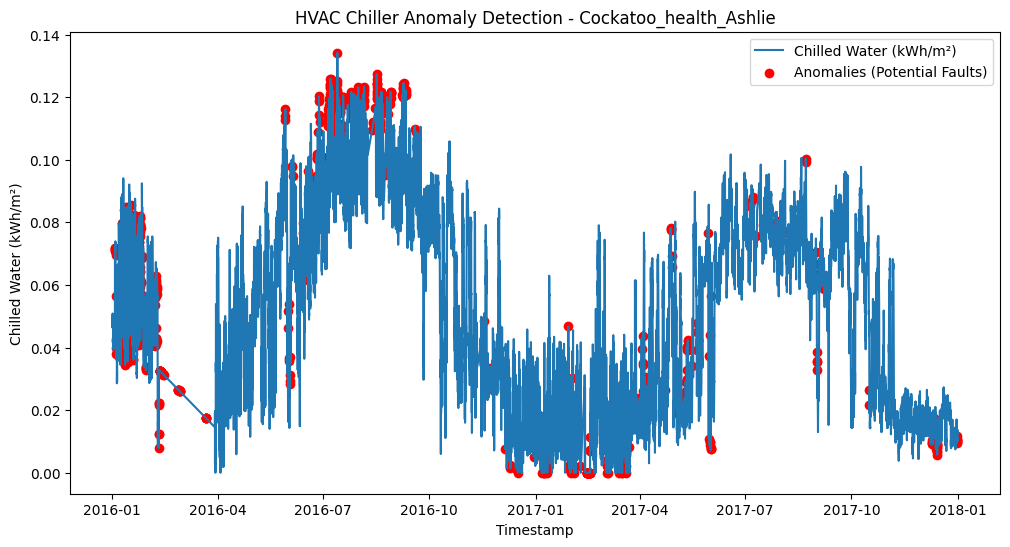

In [8]:
from sklearn.ensemble import IsolationForest

# Select one building
building = 'Cockatoo_health_Ashlie'
features = data[[building, 'airTemperature']].dropna()

# Train Isolation Forest
model = IsolationForest(contamination=0.05, random_state=42)
features['anomaly'] = model.fit_predict(features)

# Visualize anomalies
plt.figure(figsize=(12, 6))
plt.plot(features.index, features[building], label='Chilled Water (kWh/m²)')
plt.scatter(features[features['anomaly'] == -1].index,
           features[features['anomaly'] == -1][building],
           color='red', label='Anomalies (Potential Faults)')
plt.xlabel('Timestamp')
plt.ylabel('Chilled Water (kWh/m²)')
plt.title(f'HVAC Chiller Anomaly Detection - {building}')
plt.legend()
plt.savefig('anomaly_plot.png')
plt.show()

# Save results
features.to_csv('chiller_anomalies.csv')

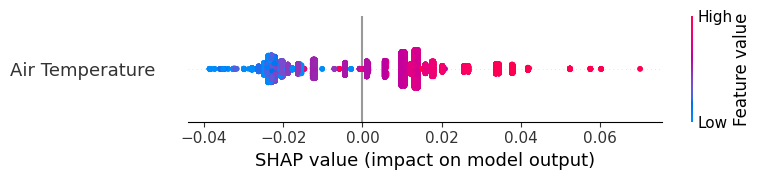

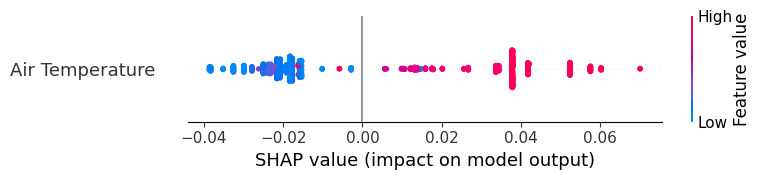

<Figure size 640x480 with 0 Axes>

In [10]:
import shap
from sklearn.ensemble import RandomForestRegressor

# Train Random Forest
X = features[['airTemperature']]
y = features[building]
model = RandomForestRegressor(random_state=42)
model.fit(X, y)

# Explain predictions
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X, feature_names=['Air Temperature'])
plt.savefig('shap_summary.png')

# Explain anomalies
anomaly_features = features[features['anomaly'] == -1][['airTemperature']]
anomaly_shap = explainer.shap_values(anomaly_features)
shap.summary_plot(anomaly_shap, anomaly_features, feature_names=['Air Temperature'])
plt.savefig('shap_anomalies.png')

In [11]:
# Heuristic
mean_usage = features[building].mean()
std_usage = features[building].std()
features['heuristic_trigger'] = features[building] > (mean_usage + 2 * std_usage)

# Log triggers
triggers = features[features['heuristic_trigger']]
print("Potential LLM Triggers (Faults):\n", triggers.head())
triggers.to_csv('heuristic_triggers.csv')

Potential LLM Triggers (Faults):
                      Cockatoo_health_Ashlie  airTemperature  anomaly  \
timestamp                                                              
2016-05-29 14:00:00                0.113864            32.8       -1   
2016-05-29 15:00:00                0.116156            32.8       -1   
2016-06-27 14:00:00                0.114339            33.3       -1   
2016-06-27 15:00:00                0.118718            33.3       -1   
2016-06-27 16:00:00                0.120231            28.3       -1   

                     heuristic_trigger  
timestamp                               
2016-05-29 14:00:00               True  
2016-05-29 15:00:00               True  
2016-06-27 14:00:00               True  
2016-06-27 15:00:00               True  
2016-06-27 16:00:00               True  


Anomaly Rate: 5.00%


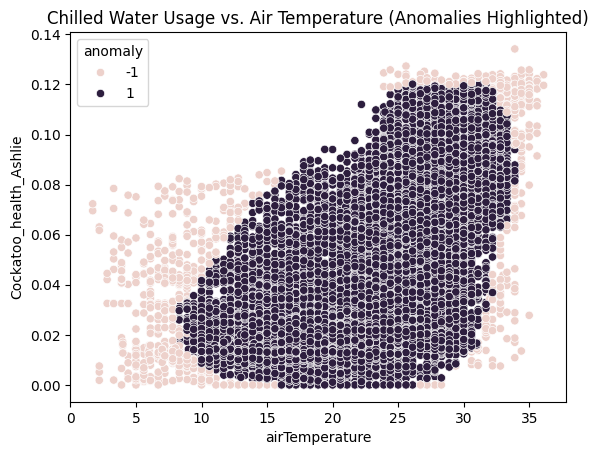

In [13]:
# Anomaly rate
anomaly_rate = (features['anomaly'] == -1).mean() * 100
print(f"Anomaly Rate: {anomaly_rate:.2f}%")

# Visualize
sns.scatterplot(x='airTemperature', y=building, hue='anomaly', data=features)
plt.title('Chilled Water Usage vs. Air Temperature (Anomalies Highlighted)')
plt.savefig('anomaly_analysis.png')
plt.show()